In [26]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import requests
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset


In [4]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Load your dataset
dataset_path = 'chessreaderdata/prediciton.csv'
prediction = pd.read_csv(dataset_path)

In [6]:
import pandas as pd
import os

# Assuming you have a DataFrame called 'predictions' with a 'id' column
# and a folder with image paths called 'chessreaderdata/images'

# Extracting IDs from image paths
image_folder_path = 'chessreaderdata/images'
image_files = os.listdir(image_folder_path)

# Extracting IDs from file names and sorting them
id_list = sorted([int(os.path.splitext(file)[0]) for file in image_files])

# Creating a mapping between the original 'id' column values and the new IDs
id_mapping = dict(zip(prediction['id'], id_list))

# Reindexing the 'id' column in the DataFrame based on the new IDs
prediction['id'] = prediction['id'].map(id_mapping)

# Now, the 'id' column in 'predictions' is modified to match the image IDs


In [7]:
prediction

,id,gameId,turnNumber,number,move_state,confidence,gl,gl2,az,rk,ab,prediction,id.1,width,height,mimetype
0,131,3,1,0,valid,0.998267,Nf3,Nf3,NF3,Nf3,Nf3,Nf3,131,300,177,image/png
1,132,3,1,1,valid,0.999023,Nf6,Nf6,Nf6,Nf6,Nf6,Nf6,132,295,177,image/png
2,133,3,2,2,valid,0.985127,93,93,93,93,g3,g3,133,294,176,image/png
3,134,3,2,3,valid,0.953389,015,015,05,d5,d5,d5,134,294,176,image/png
4,135,3,3,4,valid,0.999999,Bg2,Bg2,Bg2,Bg2,Bg2,Bg2,135,294,176,image/png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614,5505,146,2,2,valid,0.983175,c4,c4,C4,c4,e4,c4,5505,504,207,image/jpeg
1615,5506,146,2,3,valid,0.995575,c'5,c'5,C'5,c's,c5,c5,5506,507,207,image/jpeg
1616,5507,146,3,4,valid,0.999998,d5,d5,d5,d5,d5,d5,5507,504,207,image/jpeg
1617,5508,146,3,5,valid,0.998293,bs,bs,b5,b5,b5 1,b5,5508,505,208,image/jpeg


Now we are going to prepare data for training

In [10]:
labels = prediction['prediction']
labels.isna().sum()

0

In [17]:
images_folder = 'chessreaderdata/images'
image_files = []

# Iterate through the directory and add image files to the list
for file in os.listdir(images_folder):
    if file.endswith((".png", ".jpe")):  # Add or remove file types as needed
        image_files.append(file)

# Sorting the list by the file names
sorted_image_files = sorted(image_files, key=lambda x: int(x.split('.')[0]))

# Directory path to be added
directory_path = 'chessreaderdata/images/'

# Adding the directory path to each file name
full_image_paths = [directory_path + file_name for file_name in sorted_image_files]

print("Image files with full paths:", full_image_paths)   

Image files with full paths: ['chessreaderdata/images/131.png', 'chessreaderdata/images/132.png', 'chessreaderdata/images/133.png', 'chessreaderdata/images/134.png', 'chessreaderdata/images/135.png', 'chessreaderdata/images/136.png', 'chessreaderdata/images/137.png', 'chessreaderdata/images/138.png', 'chessreaderdata/images/139.png', 'chessreaderdata/images/140.png', 'chessreaderdata/images/141.png', 'chessreaderdata/images/142.png', 'chessreaderdata/images/143.png', 'chessreaderdata/images/144.png', 'chessreaderdata/images/145.png', 'chessreaderdata/images/146.png', 'chessreaderdata/images/147.png', 'chessreaderdata/images/148.png', 'chessreaderdata/images/149.png', 'chessreaderdata/images/150.png', 'chessreaderdata/images/151.png', 'chessreaderdata/images/152.png', 'chessreaderdata/images/153.png', 'chessreaderdata/images/154.png', 'chessreaderdata/images/155.png', 'chessreaderdata/images/156.png', 'chessreaderdata/images/157.png', 'chessreaderdata/images/158.png', 'chessreaderdata/i

In [18]:
prediction['image_path'] = full_image_paths

In [19]:
prediction

,id,gameId,turnNumber,number,move_state,confidence,gl,gl2,az,rk,ab,prediction,id.1,width,height,mimetype,image_path
0,131,3,1,0,valid,0.998267,Nf3,Nf3,NF3,Nf3,Nf3,Nf3,131,300,177,image/png,chessreaderdata/images/131.png
1,132,3,1,1,valid,0.999023,Nf6,Nf6,Nf6,Nf6,Nf6,Nf6,132,295,177,image/png,chessreaderdata/images/132.png
2,133,3,2,2,valid,0.985127,93,93,93,93,g3,g3,133,294,176,image/png,chessreaderdata/images/133.png
3,134,3,2,3,valid,0.953389,015,015,05,d5,d5,d5,134,294,176,image/png,chessreaderdata/images/134.png
4,135,3,3,4,valid,0.999999,Bg2,Bg2,Bg2,Bg2,Bg2,Bg2,135,294,176,image/png,chessreaderdata/images/135.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614,5505,146,2,2,valid,0.983175,c4,c4,C4,c4,e4,c4,5505,504,207,image/jpeg,chessreaderdata/images/5505.jpe
1615,5506,146,2,3,valid,0.995575,c'5,c'5,C'5,c's,c5,c5,5506,507,207,image/jpeg,chessreaderdata/images/5506.jpe
1616,5507,146,3,4,valid,0.999998,d5,d5,d5,d5,d5,d5,5507,504,207,image/jpeg,chessreaderdata/images/5507.jpe
1617,5508,146,3,5,valid,0.998293,bs,bs,b5,b5,b5 1,b5,5508,505,208,image/jpeg,chessreaderdata/images/5508.jpe


In [24]:
# Assuming your labels DataFrame is called 'labels'
# and it has columns 'image_name' and 'label'

output_labels_file = 'labels_file.txt'

# Iterate through images in the folder
with open(output_labels_file, 'w') as file:
    for index, row in prediction.iterrows():
            file.write(f"{row['image_path']}\t{row['prediction']}\n")

print("Labels file created successfully.")


Labels file created successfully.


In [53]:
# 2. Prepare your dataset
class ChessMovesDataset(Dataset):
    """ Handwritten chess moves dataset. """
    def __init__(self, labels_file, transform=None):
        self.labels = []
        self.images = []
        self.transform = transform

        # Load data
        with open(labels_file, 'r') as file:
            for line in file:
                image_path, label = line.strip().split('\t')
                if os.path.exists(image_path):
                    self.images.append(image_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = Image.open(self.images[idx]).convert("RGB") 
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        return image, label

Let’s instantiate this class and iterate through the data samples. We will print the sizes of first 4 samples and show their landmarks.

Let's first write a simple function to show an image and its labels and use it to show a sample.

0 torch.Size([3, 224, 224]) Nf3
1 torch.Size([3, 224, 224]) Nf6
2 torch.Size([3, 224, 224]) g3


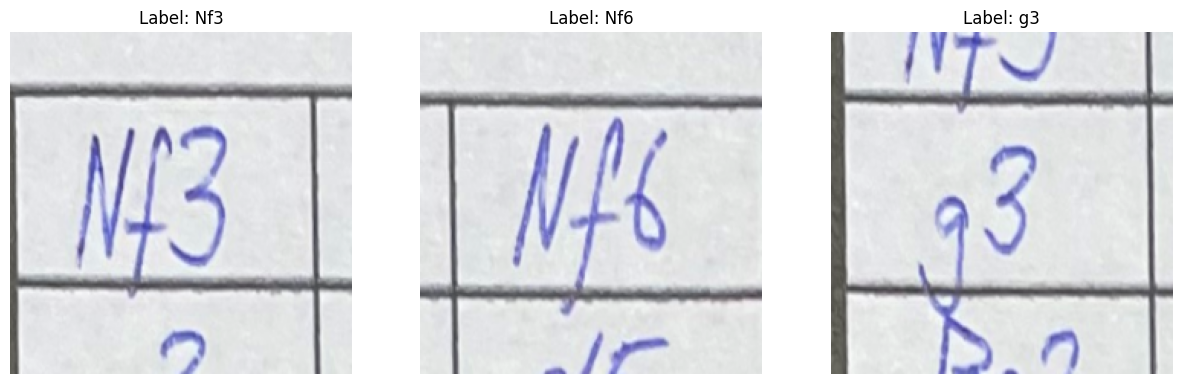

In [59]:
from torchvision import transforms


# Assuming you have a transform for the image, e.g., to tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),
    # Include any other transformations here
    # For example, normalization (if needed)
])

chess_dataset = ChessMovesDataset(labels_file='labels_file.txt', transform=transform)



# Plot the first three images and their labels
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    image_tensor, label = chess_dataset[i]  # image is now a tensor after applying the transform
    print(i, image_tensor.shape, label)
    # Convert the tensor to a numpy array and ensure it's in the range [0, 1]
    image_numpy = image_tensor.numpy().transpose(1, 2, 0)
    
    axes[i].imshow(image_numpy)
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')
plt.show()

In [60]:
dataloader = DataLoader(chess_dataset, batch_size=4, shuffle=True)

for images, labels in dataloader:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels: {labels}")


Batch images shape: torch.Size([4, 3, 224, 224])
Batch labels: ('Rxg4', 'a3', 'Nc5', 'c5')
Batch images shape: torch.Size([4, 3, 224, 224])
Batch labels: ('Bf2', 'Nd4', 'cxd4', 'Kxd8')
Batch images shape: torch.Size([4, 3, 224, 224])
Batch labels: ('Rfb8', 'Ra7', 'Nc3', 'Nc6+')
Batch images shape: torch.Size([4, 3, 224, 224])
Batch labels: ('Bh4', 'Nf6', 'd4', 'e6')
Batch images shape: torch.Size([4, 3, 224, 224])
Batch labels: ('h5', 'a3', 'Bg5', 'b6')
Batch images shape: torch.Size([4, 3, 224, 224])
Batch labels: ('Nf3', 'Rxb1', 'Nxc3', 'Rd6')
Batch images shape: torch.Size([4, 3, 224, 224])
Batch labels: ('Bb2', 'Qb4', 'Qa5', 'cxd4')
Batch images shape: torch.Size([4, 3, 224, 224])
Batch labels: ('h6', 'Nc3', 'O-O-O', 'f6')
Batch images shape: torch.Size([4, 3, 224, 224])
Batch labels: ('Kb1', 'd4', 'Rfd1', 'e4')
Batch images shape: torch.Size([4, 3, 224, 224])
Batch labels: ('a6', 'fxe5', 'a3', 'O-O-O')
Batch images shape: torch.Size([4, 3, 224, 224])
Batch labels: ('Nf3', 'axb5', 